In [1]:
import torch
import open3d.ml.torch as ml3d
import pickle

with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

pixelwise_features = torch.load("clip_features.pt").float().cpu()
# xyz_pts = torch.tensor(outputs['xyz_pts']).float().cpu()
xyz_pts = torch.load("clip_xyz.pt").float().cpu()

# sanity check
print(pixelwise_features.shape)
print(xyz_pts.shape)
print(pixelwise_features[1000])
print(xyz_pts[1000])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
torch.Size([1859473, 1024])
torch.Size([1859473, 3])
tensor([-0.0280, -0.0005, -0.0048,  ..., -0.0002, -0.0220,  0.0091])
tensor([-78.3024,  10.9022,  15.0586])


- First, since we initialized the feature matrix as a matrix of zeros, we remove any rows that didn't get assigned to a class so they don't impact the representation of any other points.

In [2]:
from time import time

zero_time = time()
zero_row_indices = torch.all(pixelwise_features == 0, dim=1)
pixelwise_features = pixelwise_features[~zero_row_indices]
xyz_pts = xyz_pts[~zero_row_indices.cpu().numpy()]
print("Time taken to remove zero rows: ", time() - zero_time)

# sanity check
print(pixelwise_features.shape)
print(xyz_pts.shape)
print(pixelwise_features[1000])
print(xyz_pts[1000])

Time taken to remove zero rows:  1.8306775093078613
torch.Size([1853585, 1408])
torch.Size([1853585, 3])
tensor([ 0.0168, -0.0106,  0.0056,  ..., -0.0118,  0.0030,  0.0056])
tensor([-81.8648,  13.5827,  15.0546])


In [3]:
i = 0
agg_rate = 0.1
pts_remaining = [xyz_pts.shape[0]]
while xyz_pts.shape[0] > 20000:
    xyz_pts, pixelwise_features = ml3d.ops.voxel_pooling(xyz_pts, pixelwise_features, agg_rate, position_fn='nearest_neighbor', feature_fn='nearest_neighbor')
    i += 1

    agg_rate += 0.1
    pts_remaining.append(xyz_pts.shape[0])

print(f"Completed voxel aggregation with {xyz_pts.shape[0]} points")

Time taken to aggregate voxels:  14.844825506210327


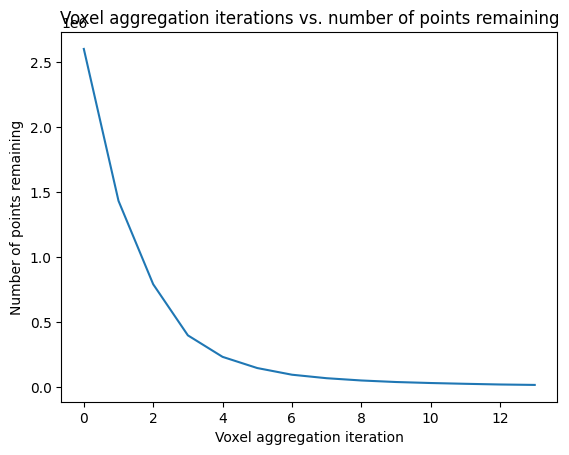

In [5]:
import matplotlib.pyplot as plt
plt.plot(pts_remaining)
plt.xlabel("Voxel aggregation iteration")
plt.ylabel("Number of points remaining")
plt.title("Voxel aggregation iterations vs. number of points remaining")
plt.show()

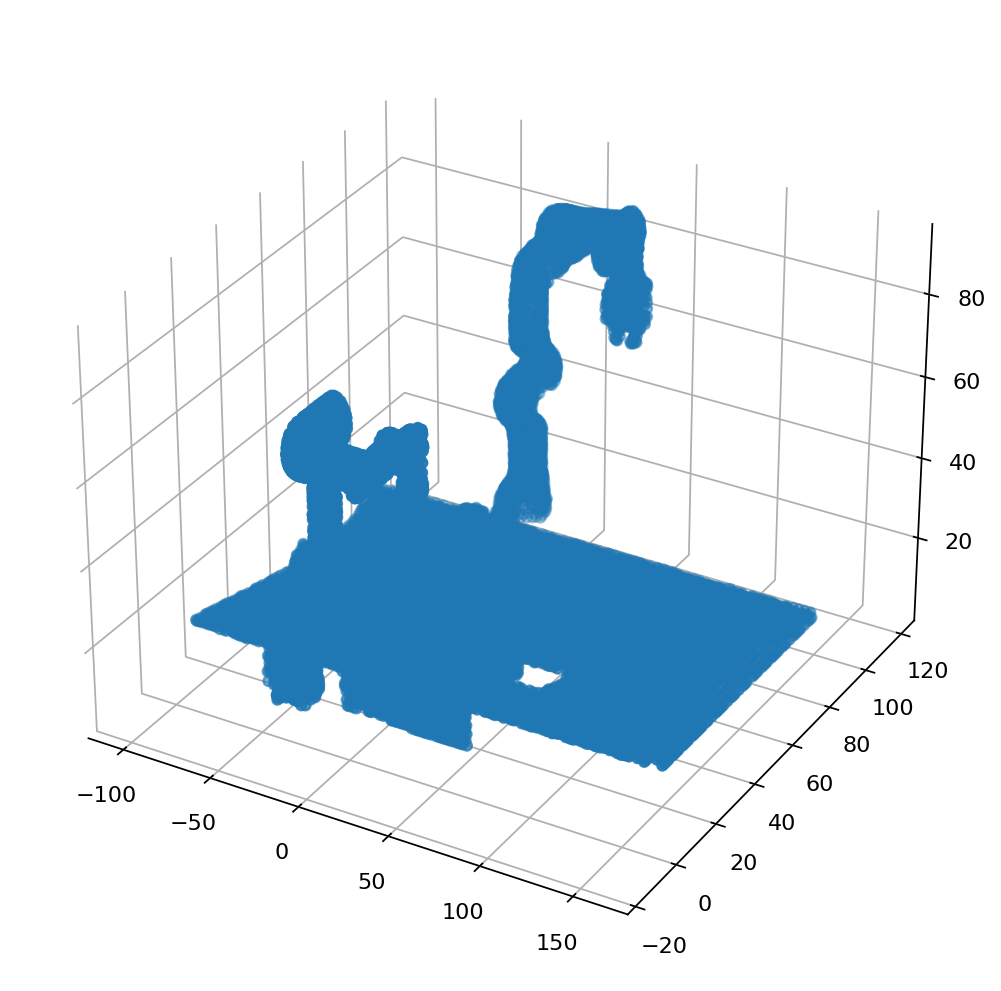

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")
background_color = (1.0, 1.0, 1.0)
ax.set_facecolor(background_color)
ax.w_xaxis.set_pane_color(background_color)  # type: ignore
ax.w_yaxis.set_pane_color(background_color)  # type: ignore
ax.w_zaxis.set_pane_color(background_color)  # type: ignore

x, y, z = (
    xyz_pts[:, 0],
    xyz_pts[:, 1],
    xyz_pts[:, 2],
)
ax.scatter(
    x,
    y,
    z,
)
plt.tight_layout(pad=0)
plt.show()

In [6]:
# now we normalize the features for the image as a whole
pixelwise_features = torch.nn.functional.normalize(pixelwise_features, dim=-1)

In [4]:
torch.save(pixelwise_features, "blip_noneva_pixelwise_rendfet_features_reduced.pt")
torch.save(xyz_pts, "blip_noneva_pixelwise_rendfet_xyz_reduced.pt")